       age_at_index  days_to_birth  year_of_birth  age_at_diagnosis  \
count    811.000000     811.000000     811.000000        811.000000   
mean      67.101110  -24674.981504    1941.061652      24674.981504   
std       13.082535    4774.094515      13.768766       4774.094515   
min       31.000000  -32872.000000    1912.000000      11391.000000   
25%       58.000000  -28443.500000    1930.000000      21519.000000   
50%       69.000000  -25324.000000    1939.000000      25324.000000   
75%       77.000000  -21519.000000    1951.000000      28443.500000   
max       90.000000  -11391.000000    1980.000000      32872.000000   

       days_to_last_follow_up  year_of_diagnosis  
count              811.000000         811.000000  
mean               775.326757        2008.162762  
std                723.387549           2.821110  
min                  0.000000        1998.000000  
25%                386.000000        2007.000000  
50%                573.000000        2009.000000  
75%

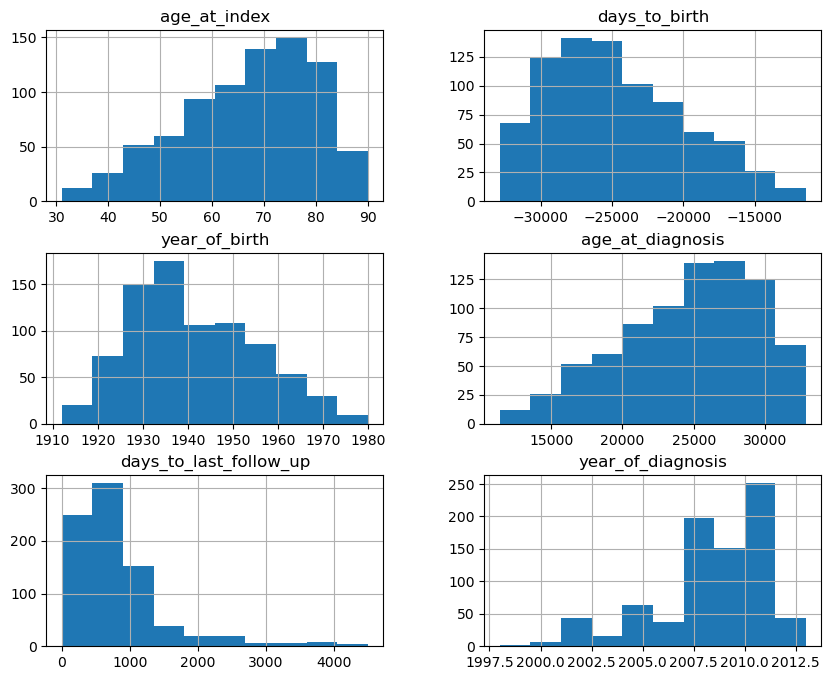

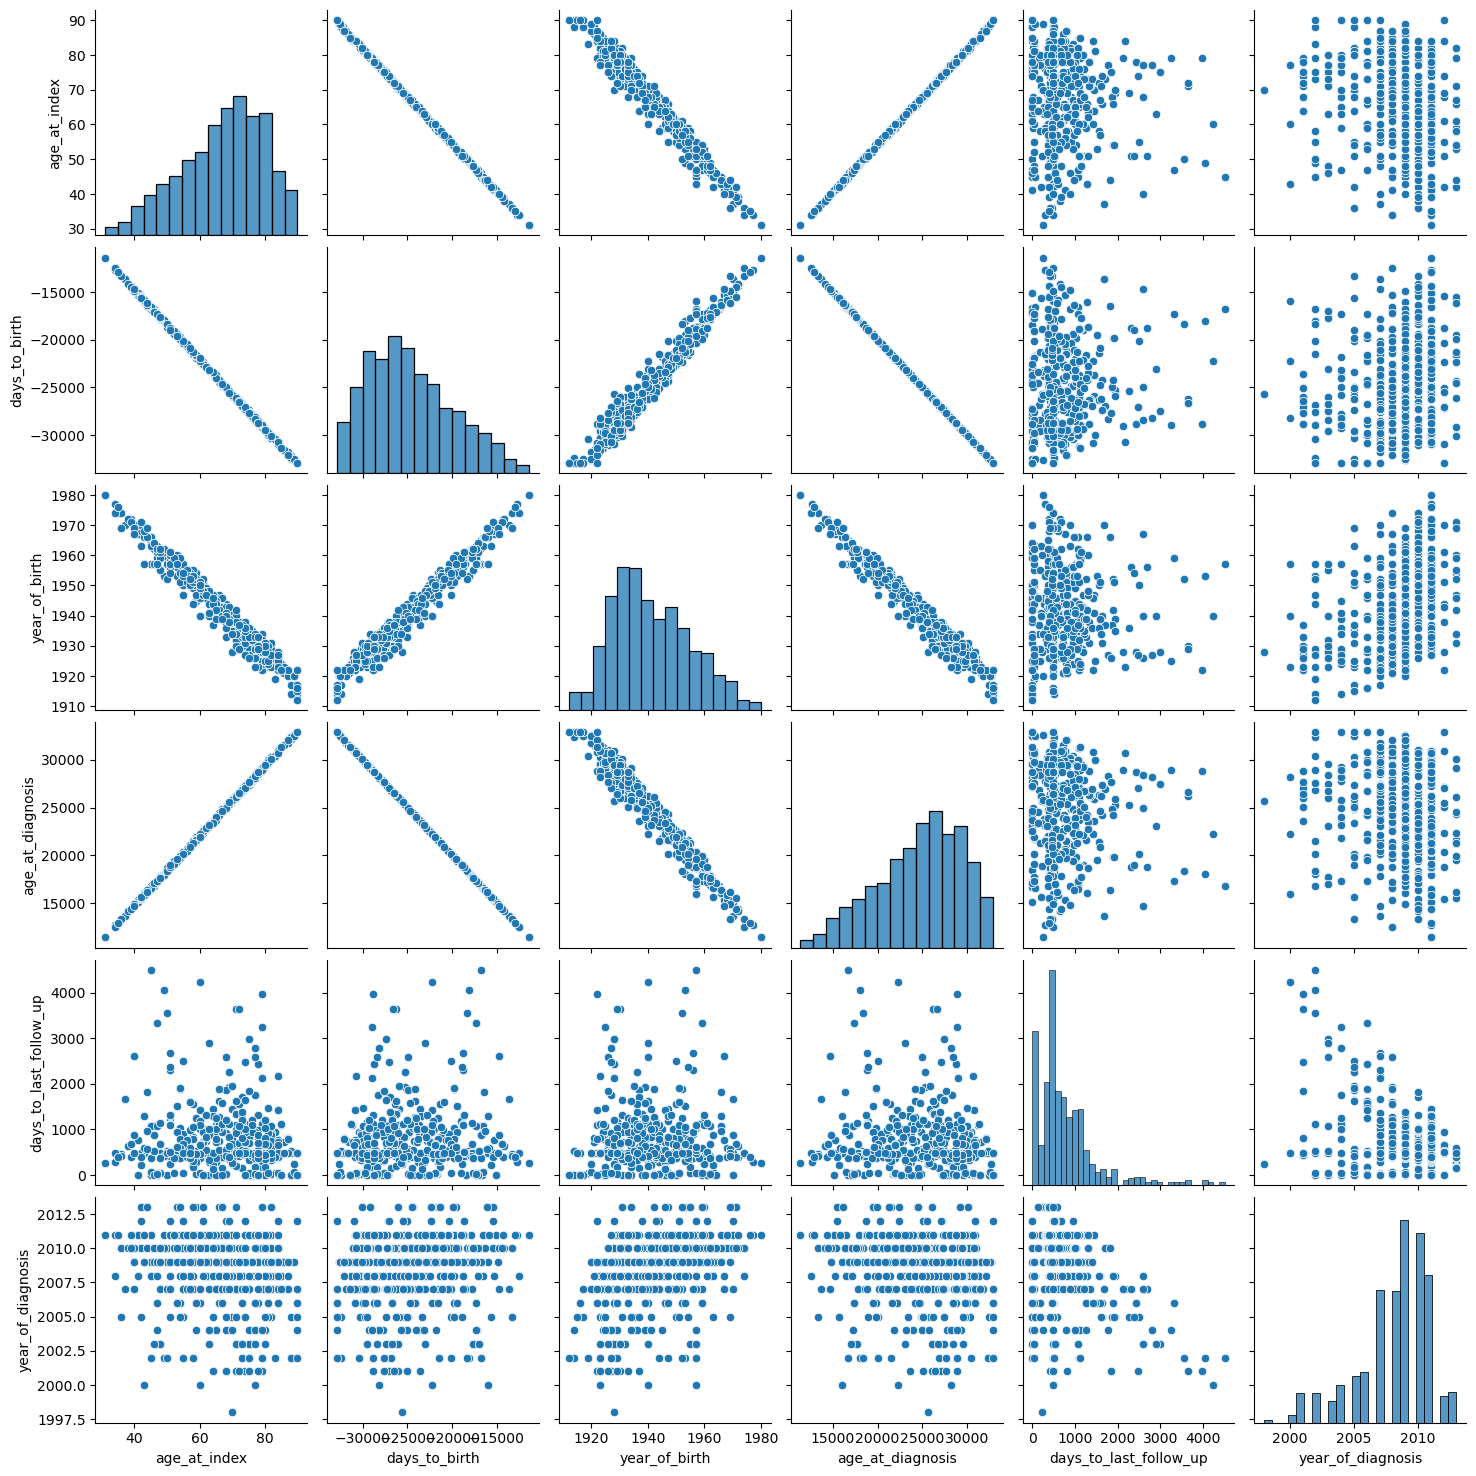

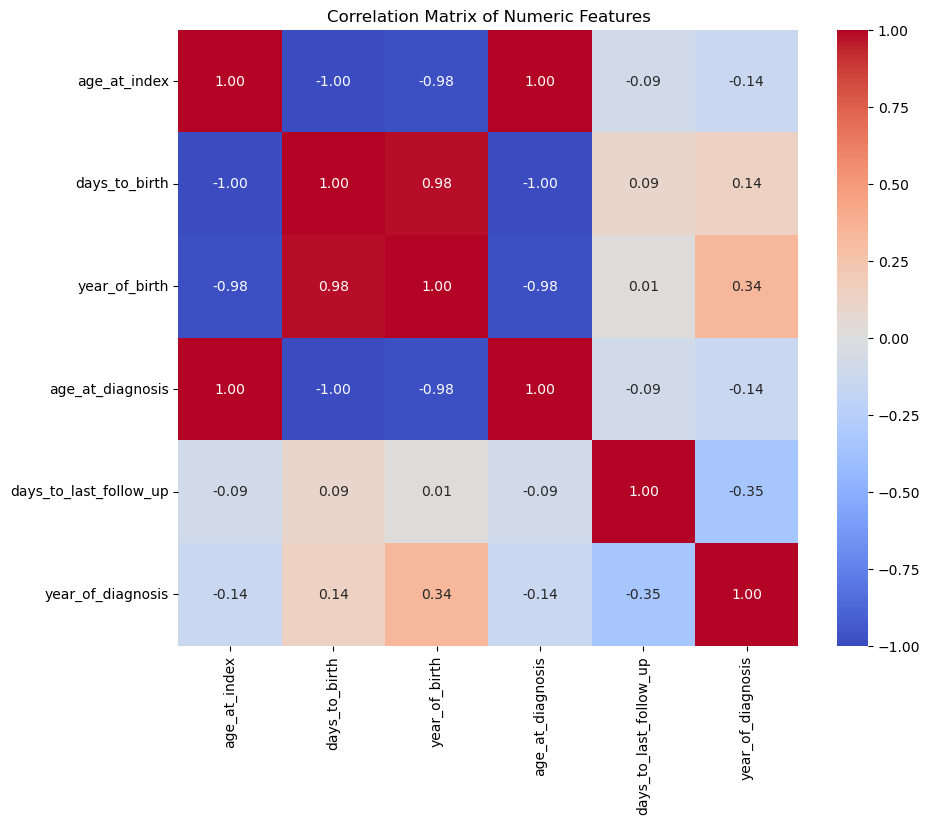

Threshold: 0.5
[[105  83]
 [  6  50]]
              precision    recall  f1-score   support

           0       0.95      0.56      0.70       188
           1       0.38      0.89      0.53        56

    accuracy                           0.64       244
   macro avg       0.66      0.73      0.62       244
weighted avg       0.82      0.64      0.66       244

Threshold: 0.6
[[161  27]
 [ 39  17]]
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       188
           1       0.39      0.30      0.34        56

    accuracy                           0.73       244
   macro avg       0.60      0.58      0.58       244
weighted avg       0.71      0.73      0.72       244



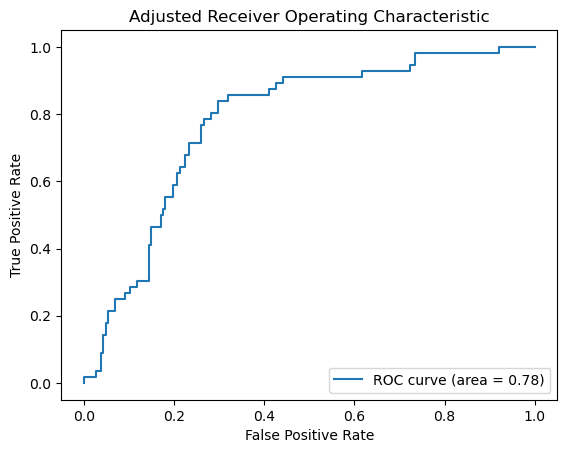

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Load the data
df = pd.read_csv('clinical_data_ready_for_analysis.csv')

# EDA
print(df.describe())
print(df.info())
print(df.isnull().sum())

# Visualizations
df.hist(figsize=(10, 8))
plt.show()
sns.pairplot(df)
plt.show()

# Select only numeric columns for correlation matrix
numeric_df = df.select_dtypes(include=[np.number])  # Ensures only numeric columns are included

# Plotting the heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

from sklearn.preprocessing import LabelEncoder
if df['vital_status'].dtype == 'object':
    le = LabelEncoder()
    df['vital_status'] = le.fit_transform(df['vital_status'])

# Drop non-numeric columns for simplicity, or you can encode them as needed
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
X = df[numeric_columns].drop('vital_status', axis=1)  # make sure to exclude the target variable
y = df['vital_status']

# Data Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.utils.class_weight import compute_class_weight

# Adjusting class weights for imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
weights = {i: class_weights[i] for i in range(len(class_weights))}


# Assuming 'weights' is properly defined and represents the class weights
model = LogisticRegression(class_weight=weights, max_iter=1000)
model.fit(X_train, y_train)

# Predict probabilities for the test set
y_prob = model.predict_proba(X_test)[:, 1]

# Initial predictions with default threshold of 0.5
y_pred_default = model.predict(X_test)

threshold = 0.5
y_pred_adjusted = (y_prob > threshold).astype(int)

# Evaluate with the new threshold
print(f"Threshold: {threshold}")
print(confusion_matrix(y_test, y_pred_adjusted))
print(classification_report(y_test, y_pred_adjusted))


# Adjust decision threshold to 0.6
threshold = 0.6
y_pred_adjusted = (y_prob > threshold).astype(int)

# Evaluate with the new threshold
print(f"Threshold: {threshold}")
print(confusion_matrix(y_test, y_pred_adjusted))
print(classification_report(y_test, y_pred_adjusted))



#plotting ROC curve with the adjusted model
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Adjusted Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
